#                                      Project - Cab Booking Prediction   
#### Submitted by- Vishal Tyagi

In [1]:
#importing Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
# from collections import Counter 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

# Task-1 Data Analysis

In [2]:
# import data
data = pd.read_csv(r"C:\Users\dell\Downloads\job-assg\Final_data_Updated_data.csv")
data.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,total number of bookings
0,5/2/2012 19:00,Summer,0,1,Clear + Few clouds,22.14,77,16.9979,504
1,9/5/2012 4:00,Fall,0,1,Clear + Few clouds,28.7,79,19.0012,5
2,1/13/2011 9:00,Spring,0,1,Clear + Few clouds,5.74,50,22.0028,139
3,11/18/2011 16:00,Winter,0,1,Clear + Few clouds,13.94,29,8.9981,209
4,9/13/2011 13:00,Fall,0,1,Clear + Few clouds,30.34,51,19.0012,184


### Data health & inconsistency checkup
there can be some incosistencies in data or it may happen that some variable don't have required data type. so checking up these things

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   datetime                  8708 non-null   object 
 1   season                    8708 non-null   object 
 2   holiday                   8708 non-null   int64  
 3   workingday                8708 non-null   int64  
 4   weather                   8708 non-null   object 
 5   temp                      8705 non-null   object 
 6   humidity                  8708 non-null   int64  
 7   windspeed                 8708 non-null   float64
 8   total number of bookings  8708 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 612.4+ KB


In [4]:
# converting variable into required data types
data['datetime'] = pd.to_datetime(data['datetime'])
data['temp'] = pd.to_numeric(data['temp'], errors='coerce')
data['holiday'] = data['holiday'].astype('str')
data['workingday'] = data['workingday'].astype('str')

In [5]:
data.describe()

,temp,humidity,windspeed,total number of bookings
count,8701.000000,8708.000000,8708.000000,8708.000000
mean,20.344837,61.649173,12.843891,193.007005
std,10.425827,19.199578,8.190314,181.552211
min,0.820000,0.000000,0.000000,1.000000
25%,13.940000,46.000000,7.001500,43.000000
50%,20.500000,61.000000,12.998000,148.000000
75%,26.240000,77.000000,16.997900,286.000000
max,500.030000,100.000000,56.996900,977.000000


In [6]:
# selecting all categorical columns
cat_cols = data.select_dtypes(include =['object']).columns
cat_cols

Index(['season', 'holiday', 'workingday', 'weather'], dtype='object')

In [7]:
for i in data[cat_cols]:
    print("----Values of----",i)
    print(data[i].value_counts(dropna=False))

----Values of---- season
Summer    2191
Fall      2185
Winter    2183
Spring    2136
Sumer        6
Fal          4
wintr        3
Name: season, dtype: int64
----Values of---- holiday
0    8460
1     248
Name: holiday, dtype: int64
----Values of---- workingday
1    5924
0    2784
Name: workingday, dtype: int64
----Values of---- weather
 Clear + Few clouds            5753
 Mist + Cloudy                 2276
 Light Snow, Light Rain         678
 Heavy Rain + Thunderstorm        1
Name: weather, dtype: int64


Season and Weather columns have some incosistencies, fixing them-

In [8]:
data['weather'] = data['weather'].str.replace(','," +")
data['season'] = data['season'].replace({'wintr': 'Winter', 'Fal': 'Fall','Sumer':'Summer'})

### Missing Value Analysis

In [9]:
data.isnull().sum()

datetime                    0
season                      0
holiday                     0
workingday                  0
weather                     0
temp                        7
humidity                    0
windspeed                   0
total number of bookings    0
dtype: int64

#### there are only 7 missing value in temp variable. let's fill them by mean or median.
Becouse temp variable data is normally distributed (mean and median are very close) we can fill missing values by Mean of values

In [10]:
# filling missing values with mean value
data['temp'].fillna(data['temp'].mean(), inplace=True)
data.isnull().sum()

datetime                    0
season                      0
holiday                     0
workingday                  0
weather                     0
temp                        0
humidity                    0
windspeed                   0
total number of bookings    0
dtype: int64

### Outlier Analysis
for checking outliers in data Boxplots are best.

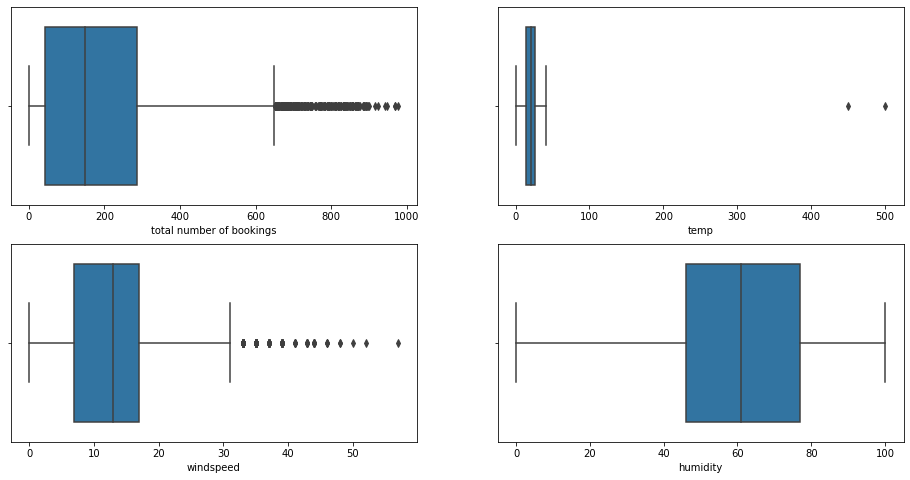

In [11]:
warnings.filterwarnings('ignore')

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.boxplot(data['total number of bookings'])
plt.subplot(2,2,2)
sns.boxplot(data['temp'])

plt.subplot(2,2,3)
sns.boxplot(data['windspeed'])
plt.subplot(2,2,4)
sns.boxplot(data['humidity'])
plt.show()

some variables like 'total number of bookings' and 'windspeed' have many outliers. so lets fix them -

In [12]:
def outlier_detect(df1,x):
    df = df1[x]
    for i in df.describe().columns:
        q1=df.describe().at["25%",i]
        q3=df.describe().at["75%",i]
        IQR=(q3-q1)
        lb=(q1-1.5*IQR)
        ub=(q3+1.5*IQR)
        x=np.array(df[i])
        p=[]
        for j in x:
             if j<lb:
                p.append(lb)
             elif j>ub:
                p.append(ub)
             else:
                p.append(j)
        df1[i]=p
    return(df1)

outlier_detect(data,['total number of bookings','temp','windspeed'])

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,total number of bookings
0,2012-05-02 19:00:00,Summer,0,1,Clear + Few clouds,22.14,77,16.9979,504.0
1,2012-09-05 04:00:00,Fall,0,1,Clear + Few clouds,28.70,79,19.0012,5.0
2,2011-01-13 09:00:00,Spring,0,1,Clear + Few clouds,5.74,50,22.0028,139.0
3,2011-11-18 16:00:00,Winter,0,1,Clear + Few clouds,13.94,29,8.9981,209.0
4,2011-09-13 13:00:00,Fall,0,1,Clear + Few clouds,30.34,51,19.0012,184.0
...,...,...,...,...,...,...,...,...,...
8703,2012-01-16 06:00:00,Spring,1,0,Clear + Few clouds,4.10,54,6.0032,13.0
8704,2011-11-10 01:00:00,Winter,0,1,Mist + Cloudy,16.40,87,0.0000,11.0
8705,2011-04-12 03:00:00,Summer,0,1,Mist + Cloudy,23.78,56,8.9981,1.0
8706,2012-11-07 01:00:00,Winter,0,1,Mist + Cloudy,11.48,61,16.9979,92.0


# Feature Engineering
Let's drive some new variables from datetime column-

In [13]:
data["month"] = pd.to_datetime(data["datetime"]).dt.strftime("%B")
data["day_of_week"] = pd.to_datetime(data["datetime"]).dt.strftime("%A")
data["hour"] = pd.to_datetime(data["datetime"], format="%B").dt.hour

In [14]:
data.drop(columns='datetime', axis=1, inplace=True)
data.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,total number of bookings,month,day_of_week,hour
0,Summer,0,1,Clear + Few clouds,22.14,77,16.9979,504.0,May,Wednesday,19
1,Fall,0,1,Clear + Few clouds,28.70,79,19.0012,5.0,September,Wednesday,4
2,Spring,0,1,Clear + Few clouds,5.74,50,22.0028,139.0,January,Thursday,9
3,Winter,0,1,Clear + Few clouds,13.94,29,8.9981,209.0,November,Friday,16
4,Fall,0,1,Clear + Few clouds,30.34,51,19.0012,184.0,September,Tuesday,13


### EDA

Exploratory data analysis is a important part in data analysis. it tell us more about data.

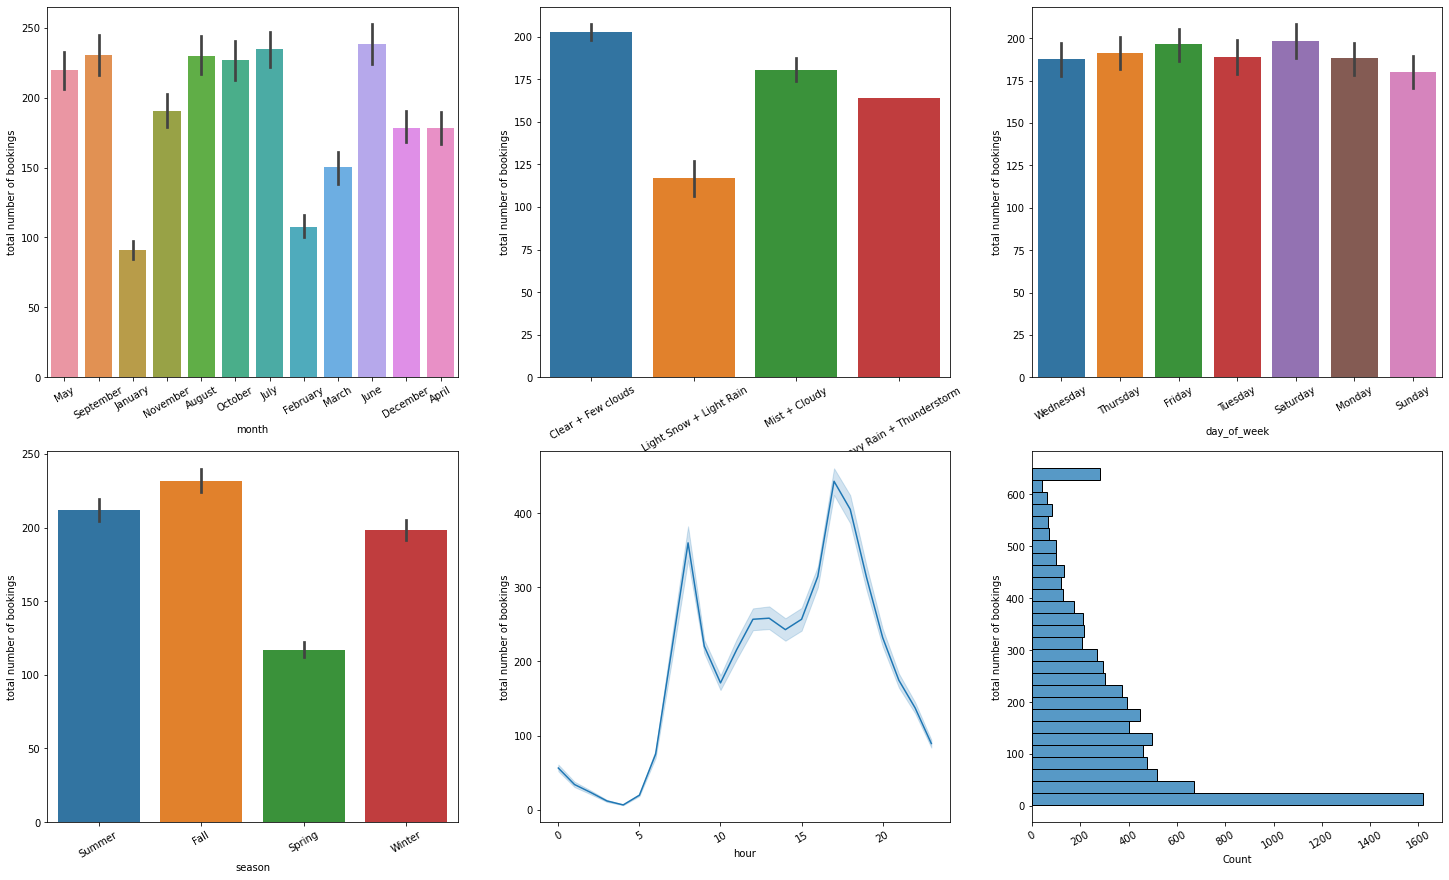

In [15]:
# creating plots between old and new variables against number of booking varaible-
plt.figure(figsize=(25,15))
plt.subplot(2,3,1)
plt.xticks(rotation=30)
sns.barplot(x = 'month', y = 'total number of bookings', data = data)
plt.subplot(2,3,2)
plt.xticks(rotation=30)
sns.barplot(x = 'weather', y ='total number of bookings', data = data)
plt.subplot(2,3,3)
plt.xticks(rotation=30)
sns.barplot(x = 'day_of_week', y = 'total number of bookings', data = data)
plt.subplot(2,3,4)
plt.xticks(rotation=30)
sns.barplot(x = 'season', y = 'total number of bookings', data = data)
plt.subplot(2,3,5)
plt.xticks(rotation=30)
sns.lineplot(x='hour', y = 'total number of bookings', data=data)
plt.subplot(2,3,6)
plt.xticks(rotation=30)
sns.histplot(data=data, y="total number of bookings")
plt.xticks(rotation=30)
plt.show()

### Summary

We can see hike in cab booking can be seen in the month of May, June, July, August, September and October..
People mostly book cabs when cloudy or there is thunderstorm.
day of week doesn't affect cab booking so much.
summer, winter and Fall are peak season for cab booking, specially Fall.
Number of booking are high Morning and Evening. Maybe people who goes to home or office book the cabs mostly.
total number of booking variable is skewed. 

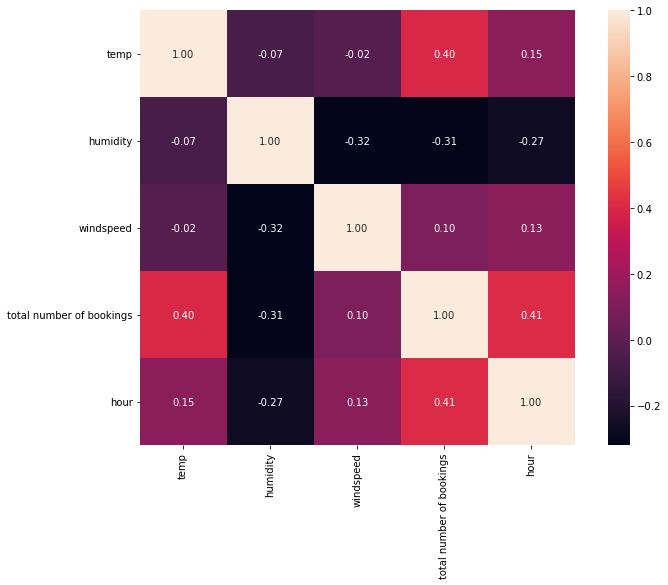

In [16]:
# Checking Correlation between diffrent features
mat = data.corr()
fig = plt.figure(figsize = (12,8))

sns.heatmap(mat, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10})
plt.show()

It can be seen by Heatmap that 'Hour' & 'total number of bookings' variables have strong positive correlation. 
while 'Humidity' and 'total number of booking' have -ve correlation, means as Humidity increases Cab booking decrease.

In [17]:
# there are some categorical variables we need to create dummy of such variables-
data["hour"] = data["hour"].astype(str)
data = pd.get_dummies(data)
data.head()

,temp,humidity,windspeed,total number of bookings,season_Fall,season_Spring,season_Summer,season_Winter,holiday_0,holiday_1,...,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
0,22.14,77,16.9979,504.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,28.70,79,19.0012,5.0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,5.74,50,22.0028,139.0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,13.94,29,8.9981,209.0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,30.34,51,19.0012,184.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Task-2 Machine Learning Model

### Spliting Data train and test dataset

In [18]:
X = data.drop('total number of bookings', axis =1)
Y = data['total number of bookings']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 5)
print(X_train.shape)
print(X_test.shape)

(6095, 58)
(2613, 58)


### Model Development

We are going to use multiple models at once, whichever model performs well. we will proceed with that

In [19]:
#--------------- Decision Tree Model---------------
D_tree = DecisionTreeRegressor()
D_tree.fit(X_train,y_train)
# predict the model
DT_pred = D_tree.predict(X_test)

#-------------- RANDOM FOREST----------------------
R_forest = RandomForestRegressor( random_state = 5)
R_forest.fit(X_train,y_train)
# predict the model
RF_pred = R_forest.predict(X_test)

#-------------- Gradient Boosting----------------------
G_boosting = GradientBoostingRegressor()
G_boosting.fit(X_train, y_train)
GB_pred = G_boosting.predict(X_test)

#---------------Light-GBM------------------------------
lbm_mdl = LGBMRegressor()
lbm_mdl.fit(X_train, y_train)
lbm_pred = lbm_mdl.predict(X_test)

### Model Evaluation

In [20]:
# it is regression model, so best we can choose is r-squared and rmse to evaluate model-
print("-------------:------R squared-----|-------MSE--------;")
print("Decision Tree:", r2_score(y_test, DT_pred),"|",mean_squared_error(y_test, DT_pred))
print("Random Forest:", r2_score(y_test, RF_pred),"|", mean_squared_error(y_test, RF_pred))
print("GBM          :", r2_score(y_test, GB_pred),"|",mean_squared_error(y_test, GB_pred))
print("Light-GBM    :", r2_score(y_test, lbm_pred),"|",mean_squared_error(y_test, lbm_pred))

-------------:------R squared-----|-------MSE--------;
Decision Tree: 0.6776071322421129 | 9469.38672024493
Random Forest: 0.8333983010302212 | 4893.457869481891
GBM          : 0.7318180934078174 | 7877.091706635165
Light-GBM    : 0.8550185106950204 | 4258.4248189290765


### Hyperparameter-tuning
Because LGBM-Regression is perfoming better then any other model. we will try to optimize this one
.

In [21]:
map_grid = {'learning_rate': [0.01,0.08,0.1], 'n_estimators': [300, 500, 1000, 1200],
               'num_leaves': [8, 12, 16,20, 25],  
               'subsample': [0.2,0.4,0.7, 0.75], 'reg_alpha': [1, 2, 6],
               'reg_lambda': [1, 2, 6]}

lgbm_random = GridSearchCV(estimator = lbm_mdl, param_grid = map_grid, 
                          cv = 2, n_jobs = -1, verbose = 20)
#fitting the model
lgbm_random = lgbm_random.fit(X_train, y_train)

#Predicting test data
y_train_pred_lgbm = lgbm_random.predict(X_train)
y_pred_lgbm = lgbm_random.predict(X_test)

print("R squared:",r2_score(y_test,y_pred_lgbm))
print("MSE :", mean_squared_error(y_test, y_pred_lgbm))

Fitting 2 folds for each of 2160 candidates, totalling 4320 fits
R squared: 0.8697707799071916
MSE : 3825.118266142303


##### Model is performing better then before. we can manual Tuning these parameters. but for now we are freezing these parameters as final

In [22]:
# Model's Best parameters
lgbm_random.best_params_

{'learning_rate': 0.08,
 'n_estimators': 1200,
 'num_leaves': 16,
 'reg_alpha': 1,
 'reg_lambda': 2,
 'subsample': 0.2}

<AxesSubplot:>

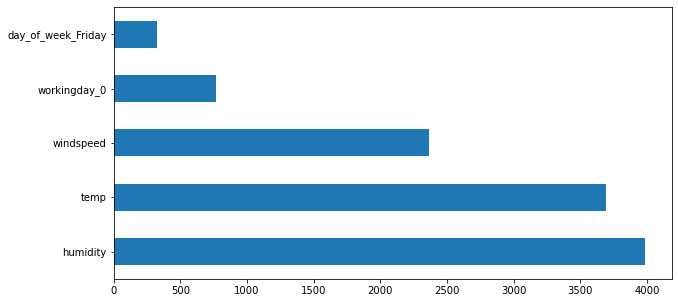

In [23]:
# FEATURE IMPORTANCE - top 5 only
feat_importances = pd.Series(lgbm_random.best_estimator_.feature_importances_, index=X_train.columns)
f, ax = plt.subplots(figsize=(10,5))
feat_importances.nlargest(5).plot(kind='barh')